<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/458_Assignment2_featureExtractionProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the following code we will set up both dense neural networks and convolutional neural networks to classify images of articles of clothing from the Fashion MNIST dataset into ten classes. We will set up five different experiments in order to explore the impact different nodes on the network and to determine what features in the images are detected by the nodes. 


Notebook uses portions of code written by Edward Arroyo and Daniel Jensen

##Setup and Preprocessing

In [64]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.3.0-tf'

In [65]:
tf.__version__

'2.2.0-rc4'

In [0]:
from keras import metrics

In [0]:
# neccessary for K.gradient to work in TensorFlow 2.x
# only needed for the "Finding a pattern the hidden node maximally responds to" section below.
# but disabled to make Tensorboard work...
tf.compat.v1.disable_eager_execution() 

In [0]:
# Set see in order to achieve consistent results across runs
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Import Fashion-MNIST dataset

Using data from collected from European fasion platform Zalondo. The dataset has been compiled to mimic the structure of the MNIST dataset. It consists of 60,000 training images and 10,000 testing images. All of the images are in grayscale and 28x28 pixels. Each of the images is labeled with an integer 0-9 that corresponds to the following classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

More information can be found here: https://github.com/zalandoresearch/fashion-mnist 

In [69]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [70]:
#Store copy of training images in order to easily view images even after transformations are performed
example_train_images = train_images.copy()
example_train_images.shape

(60000, 28, 28)

In [71]:
# The distribution of the classes appears to be uniform
from collections import Counter
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [0]:
# https://github.com/zalandoresearch/fashion-mnist
# https://www.tensorflow.org/tutorials/keras/classification

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Example of a single sample, a 28x28 pixel image of an article of clothing

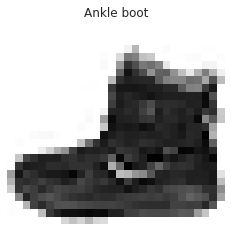

In [73]:
#https://matplotlib.org/tutorials/colors/colormaps.html?highlight=colormap
plt.imshow(train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

### Prepare the data


In [0]:
# Reshape the data into the shape that the network expects
train_images = train_images.reshape((60000, 28 * 28))

# Scale the data to [0,1] interval
train_images = train_images.astype('float32') / 255

# Do the same for the test dataset
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

Set aside 5,000 samples from the training data to use as the validation set.

In [0]:
val_images, train_images = train_images[:5000], train_images[5000:]
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

# Experiment 1
'Best' DNN model from assignment 1 which used the MNIST dataset. 
Consists of a single hidden layer with 700 nodes, sigmoid activation, and Adam optimizer. The dropout layer was omitted for this experiment.

### Build and compile the model

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(700, activation='sigmoid', input_shape=(28*28,)))
model.add(layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])

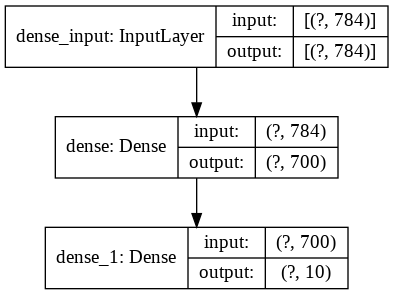

In [77]:
# Plot a graph of the model
keras.utils.plot_model(model, show_shapes=True) 

### Create a callback to get training times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

### Train the model
Using 20 epochs and batch size 100

In [79]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 1s 20us/sample - loss: 0.5633 - accuracy: 0.8045 - val_loss: 0.4248 - val_accuracy: 0.8502
Epoch 2/20
55000/55000 [==============================] - 1s 20us/sample - loss: 0.4224 - accuracy: 0.8483 - val_loss: 0.4032 - val_accuracy: 0.8532
Epoch 3/20
55000/55000 [==============================] - 1s 20us/sample - loss: 0.3864 - accuracy: 0.8612 - val_loss: 0.3806 - val_accuracy: 0.8640
Epoch 4/20
55000/55000 [==============================] - 1s 20us/sample - loss: 0.3586 - accuracy: 0.8703 - val_loss: 0.3634 - val_accuracy: 0.8676
Epoch 5/20
55000/55000 [==============================] - 1s 20us/sample - loss: 0.3393 - accuracy: 0.8771 - val_loss: 0.3371 - val_accuracy: 0.8768
Epoch 6/20
55000/55000 [==============================] - 1s 20us/sample - loss: 0.3197 - accuracy: 0.8831 - val_loss: 0.3432 - val_accuracy: 0.8770
Epoch 7/20
55000/55000 [==============================] -

In [80]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

22.253961

### Test the model

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

In [83]:
test_time = test_rt.process_time
test_time # in seconds

0.430279

### Create a dataframe for the training and test statistics

In [84]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [85]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.210944,0.922055,0.289889,0.8956
16,0.206177,0.924582,0.288760,0.8970
17,0.197847,0.926709,0.294415,0.8910
18,0.191166,0.929655,0.291875,0.8984
19,0.184486,0.931509,0.284880,0.8960


In [86]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers)') # model name to appears first
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc #incorporate test results
results_df['training time (sec)'] = train_time    
results_df['testing time (sec)'] = test_time      # testing time appears last
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,DNN (2 layers),0.184486,0.931509,0.28488,0.896,0.326124,0.8868,22.253961,0.430279


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

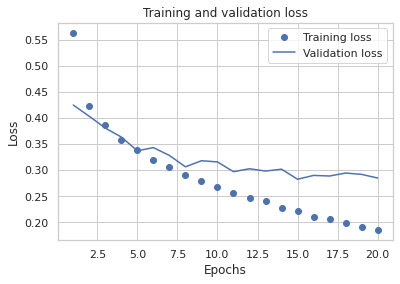

In [87]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

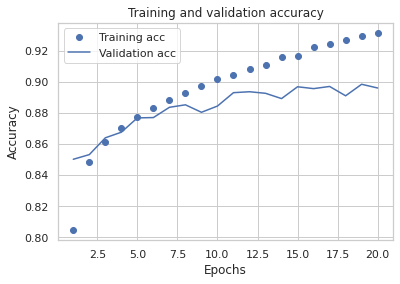

In [88]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Experiment 2
This DNN is the same as in Experiment 1, but with an additional hidden layer.
784 input nodes, hidden layer with 700 nodes, hidden layer with **370** nodes, and 10 output nodes.

## Build and compile the model

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(700, activation='sigmoid', input_shape=(28*28,)))
model.add(layers.Dense(370, activation='sigmoid'))
model.add(layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])

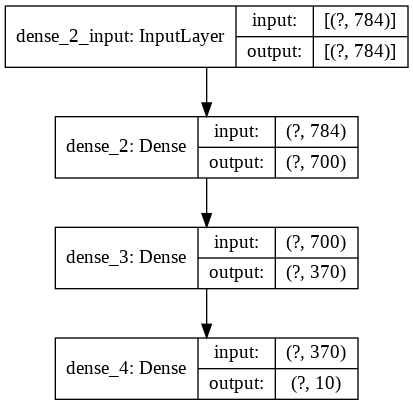

In [90]:
# Plot a graph of the model
keras.utils.plot_model(model, show_shapes=True) 

## Train the model
Using 20 epochs and batch size 100

In [91]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 1s 24us/sample - loss: 0.6047 - accuracy: 0.7842 - val_loss: 0.4301 - val_accuracy: 0.8486
Epoch 2/20
55000/55000 [==============================] - 1s 23us/sample - loss: 0.4084 - accuracy: 0.8517 - val_loss: 0.3675 - val_accuracy: 0.8678
Epoch 3/20
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3653 - accuracy: 0.8661 - val_loss: 0.3480 - val_accuracy: 0.8726
Epoch 4/20
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3410 - accuracy: 0.8733 - val_loss: 0.3557 - val_accuracy: 0.8664
Epoch 5/20
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3187 - accuracy: 0.8848 - val_loss: 0.3236 - val_accuracy: 0.8858
Epoch 6/20
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3037 - accuracy: 0.8880 - val_loss: 0.3540 - val_accuracy: 0.8624
Epoch 7/20
55000/55000 [==============================] -

In [92]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

24.296363

## Test the model

In [93]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.34026717511415483, 0.8893)

In [94]:
test_time = test_rt.process_time
test_time # in seconds

0.404731

##Add training and testing statistics to the results dataframe

In [95]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','DNN (3 layers)') # want the model name to appear first
results_df2['test_loss'] = test_loss #incorporate test results
results_df2['test_accuracy'] = test_acc
results_df2['training time (sec)'] = train_time     
results_df2['testing time (sec)'] = test_time      # testing time appears last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,DNN (3 layers),0.165208,0.938764,0.303697,0.8998,0.340267,0.8893,24.296363,0.404731


Add the new data to results_df

In [96]:
results_df=results_df.append(results_df2,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.184486,0.931509,0.284880,0.8960,0.326124,0.8868,22.253961,0.430279
1,DNN (3 layers),0.165208,0.938764,0.303697,0.8998,0.340267,0.8893,24.296363,0.404731


## Plotting the performance 

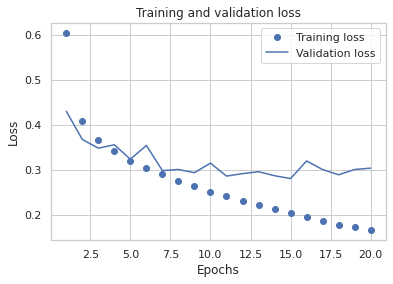

In [97]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

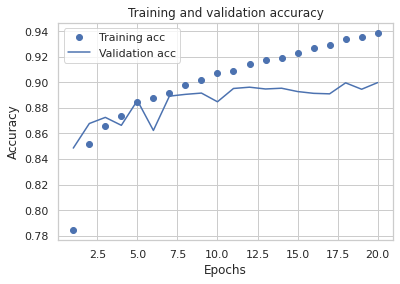

In [98]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Experiment 3
CNN with 2 convolution/max pooling layers and no dropout.

##Prepare the data
Must reshape the data

In [99]:
train_images.shape

(55000, 784)

In [0]:
train_images = train_images.reshape((55000, 28, 28, 1))

test_images = test_images.reshape((10000, 28, 28, 1))

val_images = val_images.reshape((5000, 28, 28, 1))

##Build and compile the model


In [0]:
# CNN with 2 convolution/max pooling layers


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

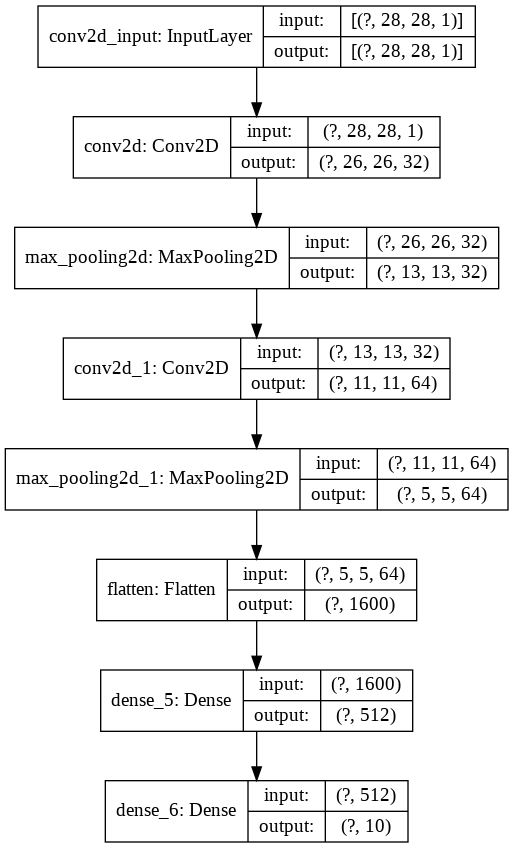

In [102]:
keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [103]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 2s 34us/sample - loss: 0.4895 - accuracy: 0.8218 - val_loss: 0.3389 - val_accuracy: 0.8830
Epoch 2/20
55000/55000 [==============================] - 2s 33us/sample - loss: 0.3175 - accuracy: 0.8839 - val_loss: 0.2783 - val_accuracy: 0.8996
Epoch 3/20
55000/55000 [==============================] - 2s 33us/sample - loss: 0.2674 - accuracy: 0.9017 - val_loss: 0.2636 - val_accuracy: 0.9040
Epoch 4/20
55000/55000 [==============================] - 2s 33us/sample - loss: 0.2363 - accuracy: 0.9130 - val_loss: 0.2349 - val_accuracy: 0.9150
Epoch 5/20
55000/55000 [==============================] - 2s 34us/sample - loss: 0.2102 - accuracy: 0.9226 - val_loss: 0.2797 - val_accuracy: 0.9038
Epoch 6/20
55000/55000 [==============================] - 2s 33us/sample - loss: 0.1897 - accuracy: 0.9289 - val_loss: 0.2273 - val_accuracy: 0.9182
Epoch 7/20
55000/55000 [==============================] -

In [104]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

36.74123

## Test the model

In [105]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.45011717852950095, 0.9098)

In [106]:
test_time = test_rt.process_time
test_time # in seconds

0.470963

##Add training and test statistics to results dataframe

In [107]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.044578,0.984309,0.331646,0.9184
16,0.038302,0.985600,0.348027,0.9172
17,0.034415,0.988291,0.369290,0.9182
18,0.032223,0.988509,0.366679,0.9208
19,0.026785,0.990636,0.402103,0.9146


In [108]:
results_df3 = history_df.iloc[-1:].copy()
results_df3.insert(0,'model','CNN (2 layers)') # want the model name to appear first
results_df3['test_loss'] = test_loss #incorporate test results
results_df3['test_accuracy'] = test_acc
results_df3['training time (sec)'] = train_time     
results_df3['testing time (sec)'] = test_time      # testing time appears last
results_df3

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers),0.026785,0.990636,0.402103,0.9146,0.450117,0.9098,36.74123,0.470963


In [109]:
results_df=results_df.append(results_df3,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.184486,0.931509,0.284880,0.8960,0.326124,0.8868,22.253961,0.430279
1,DNN (3 layers),0.165208,0.938764,0.303697,0.8998,0.340267,0.8893,24.296363,0.404731
2,CNN (2 layers),0.026785,0.990636,0.402103,0.9146,0.450117,0.9098,36.741230,0.470963


## Plotting the performance 

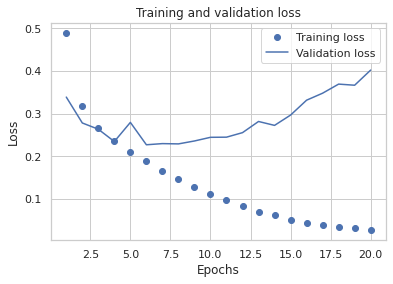

In [110]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

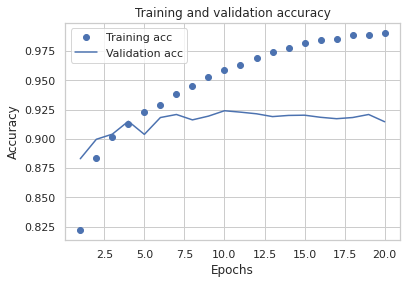

In [111]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
# save the model
model.save("experiment3.h5")

#Experiment 4
CNN with 3 convolution/max pooling layers

##Build and compile the model

In [0]:
# CNN with 3 convolution/max pooling layers


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

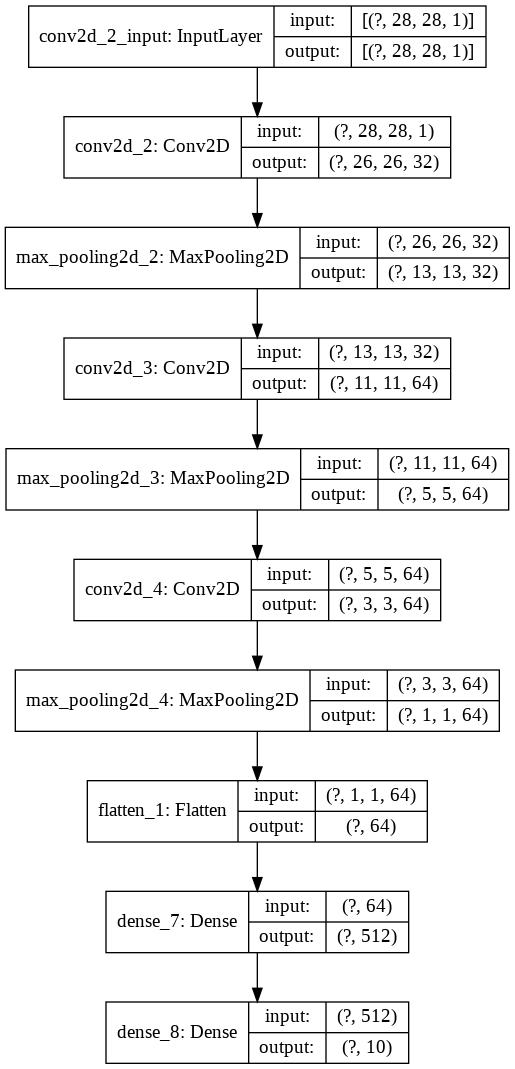

In [114]:
keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [115]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6964 - accuracy: 0.7435 - val_loss: 0.4665 - val_accuracy: 0.8296
Epoch 2/20
55000/55000 [==============================] - 2s 35us/sample - loss: 0.4401 - accuracy: 0.8383 - val_loss: 0.4048 - val_accuracy: 0.8502
Epoch 3/20
55000/55000 [==============================] - 2s 35us/sample - loss: 0.3781 - accuracy: 0.8613 - val_loss: 0.3452 - val_accuracy: 0.8746
Epoch 4/20
55000/55000 [==============================] - 2s 35us/sample - loss: 0.3410 - accuracy: 0.8738 - val_loss: 0.3496 - val_accuracy: 0.8714
Epoch 5/20
55000/55000 [==============================] - 2s 35us/sample - loss: 0.3129 - accuracy: 0.8839 - val_loss: 0.3196 - val_accuracy: 0.8834
Epoch 6/20
55000/55000 [==============================] - 2s 36us/sample - loss: 0.2878 - accuracy: 0.8926 - val_loss: 0.2942 - val_accuracy: 0.8948
Epoch 7/20
55000/55000 [==============================] -

In [116]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

39.435362

## Test the model

In [117]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.35598787281513217, 0.9002)

In [118]:
test_time = test_rt.process_time
test_time # in seconds

0.493949

##Add training and test statistics to results dataframe

In [119]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.157417,0.941109,0.315744,0.8962
16,0.146098,0.944764,0.332031,0.8956
17,0.135478,0.950109,0.307670,0.9018
18,0.133773,0.949036,0.342435,0.8938
19,0.120504,0.955345,0.330610,0.9016


In [120]:
results_df4 = history_df.iloc[-1:].copy()
results_df4.insert(0,'model','CNN (3 layers)') # want the model name to appear first
results_df4['test_loss'] = test_loss #incorporate test results
results_df4['test_accuracy'] = test_acc
results_df4['training time (sec)'] = train_time     
results_df4['testing time (sec)'] = test_time      # testing time appears last
results_df4

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers),0.120504,0.955345,0.33061,0.9016,0.355988,0.9002,39.435362,0.493949


In [121]:
results_df=results_df.append(results_df4,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.184486,0.931509,0.284880,0.8960,0.326124,0.8868,22.253961,0.430279
1,DNN (3 layers),0.165208,0.938764,0.303697,0.8998,0.340267,0.8893,24.296363,0.404731
2,CNN (2 layers),0.026785,0.990636,0.402103,0.9146,0.450117,0.9098,36.741230,0.470963
3,CNN (3 layers),0.120504,0.955345,0.330610,0.9016,0.355988,0.9002,39.435362,0.493949


In [122]:
# #Export results dataframe

# from google.colab import files

# results_df.to_csv('A2_noDropout.csv')
# files.download('A2_noDropout.csv')

MessageError: ignored

## Plotting the performance 

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
# save the model. We will visualize its intermediate activations in Result2
model.save("experiment4")

#Experiment 5: Add dropout layers; test number of dense layer nodes (256)


##Build and compile the model

In [0]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

# Final Model
4 layer CNN with two layers of padding


##Build and compile the model

In [0]:
model = models.Sequential()
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer ='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [127]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=30,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 8s 151us/sample - loss: 0.3789 - accuracy: 0.8592 - val_loss: 0.3055 - val_accuracy: 0.8828
Epoch 2/30
55000/55000 [==============================] - 8s 148us/sample - loss: 0.3170 - accuracy: 0.8829 - val_loss: 0.2553 - val_accuracy: 0.9012
Epoch 3/30
55000/55000 [==============================] - 8s 149us/sample - loss: 0.2844 - accuracy: 0.8941 - val_loss: 0.2389 - val_accuracy: 0.9066
Epoch 4/30
55000/55000 [==============================] - 8s 149us/sample - loss: 0.2585 - accuracy: 0.9043 - val_loss: 0.2312 - val_accuracy: 0.9074
Epoch 5/30
55000/55000 [==============================] - 8s 149us/sample - loss: 0.2461 - accuracy: 0.9093 - val_loss: 0.2182 - val_accuracy: 0.9172
Epoch 6/30
55000/55000 [==============================] - 8s 150us/sample - loss: 0.2290 - accuracy: 0.9145 - val_loss: 0.2059 - val_accuracy: 0.9214
Epoch 7/30
55000/55000 [===========================

In [128]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

246.785406

In [129]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  320       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                 

## Test the model

In [130]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])
test_loss, test_acc

(0.21309751297831536, 0.9304)

In [131]:
test_time = test_rt.process_time
test_time # in seconds

0.618822

##Add training and test statistics to results dataframe

In [132]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
25,0.135298,0.948873,0.186377,0.9328
26,0.133213,0.949091,0.190980,0.9312
27,0.131652,0.949418,0.198489,0.9310
28,0.125764,0.951909,0.195066,0.9320
29,0.128535,0.951491,0.183866,0.9344


In [133]:
results_dfnew = history_df.iloc[-1:].copy()
results_dfnew.insert(0,'model','CNN (4 layers), padding2, epochs30b') # want the model name to appear first
results_dfnew['test_loss'] = test_loss #incorporate test results
results_dfnew['test_accuracy'] = test_acc
results_dfnew['training time (sec)'] = train_time     
results_dfnew['testing time (sec)'] = test_time      # testing time appears last
results_dfnew

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
29,"CNN (4 layers), padding2, epochs30b",0.128535,0.951491,0.183866,0.9344,0.213098,0.9304,246.785406,0.618822


In [134]:
results_df=results_df.append(results_dfnew,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.184486,0.931509,0.284880,0.8960,0.326124,0.8868,22.253961,0.430279
1,DNN (3 layers),0.165208,0.938764,0.303697,0.8998,0.340267,0.8893,24.296363,0.404731
2,CNN (2 layers),0.026785,0.990636,0.402103,0.9146,0.450117,0.9098,36.741230,0.470963
3,CNN (3 layers),0.120504,0.955345,0.330610,0.9016,0.355988,0.9002,39.435362,0.493949
4,"CNN (4 layers), padding2, epochs30b",0.128535,0.951491,0.183866,0.9344,0.213098,0.9304,246.785406,0.618822


## Plotting the performance 

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
# Save model
model.save("finalModel")

# Feature Extraction from Final Model

In [0]:
# img_path = '/Users/fchollet/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg'

# from keras.preprocessing import image                             ❶
# import numpy as np

# img = image.load_img(img_path, target_size=(150, 150))
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)
# img_tensor /= 255.                                                ❷
# print(img_tensor.shape) 

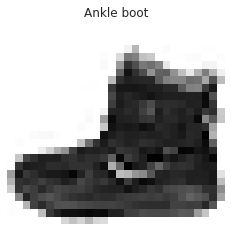

In [136]:
#https://matplotlib.org/tutorials/colors/colormaps.html?highlight=colormap
plt.imshow(example_train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

In [0]:
image = train_images[0]

In [138]:
image.shape

(28, 28, 1)

In [142]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[2:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

AttributeError: ignored